In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from scipy.integrate import simpson 
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit, jit

In [54]:
@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


@jit
def spectral_window(min_wl, max_wl, window_size):
    windows_array = np.arange(min_wl, max_wl, window_size)
    species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
    dom = np.full((25, len(windows_array)), '...')
    indices = range(len(windows_array))
    models = list(df['Model Name'])
    models.insert(0, models.pop())
    for index_model, model in tqdm(enumerate(models)):
        for index_window, window in enumerate(windows_array):
            if index_window in indices:
                dominant_specie = '...'
                max_flux = -np.inf
                for specie in species:
                    flux = calc_flux(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(),
                                     df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy(),
                                     [window, window + window_size])
                    if flux > max_flux:
                        max_flux = flux
                        dominant_specie = specie
                dom[index_model, index_window] = dominant_specie
        same_values = np.all(dom[:index_model + 1] == dom[:index_model + 1][0, :], axis=0)
        indices = np.where(same_values)[0].tolist()
    return windows, dom[-1]

In [4]:
# Open the data 
with open('ModelData.pkl', 'rb') as f:
    df = pickle.load(f)
df

,Model Name,C Value,O Value,CO Value,FLiTs Wavelength,FLiTs Flux,ProDiMo C2H2_H,ProDiMo CH4_H,ProDiMo CO,ProDiMo CO2_H,...,FLiTs HCN Flux,FLiTs HCN Wavelength,FLiTs NH3 Flux,FLiTs NH3 Wavelength,FLiTs NO Flux,FLiTs NO Wavelength,FLiTs O2 Flux,FLiTs O2 Wavelength,FLiTs OH Flux,FLiTs OH Wavelength
0,C_-0.5_O_-0.5_CO_0.45,-0.5,-0.5,0.45,"[4.90216873, 4.90218508, 4.90220144, 4.9022177...","[9.290666707434392e-05, 9.36347640732027e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009307341873190812, 0.0025946503251030473, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[6.378495698844411e-07, 6.387100354166009e-07,...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[0.0, -5.551115123125783e-17, -5.5511151231257...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[3.0270818582311954e-06, 3.139984831007636e-06...","[4.94498186, 4.94499836, 4.94501485, 4.9450313...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.82143071, 5.82145013, 5.82146955, 5.8214889...","[1.0257067417640542e-09, 1.0500832980930852e-0...","[5.04256821, 5.04258503, 5.04260185, 5.0426186..."
1,C_-0.5_O_-0.25_CO_0.2570,-0.5,-0.25,0.2570,"[4.90218508, 4.90220144, 4.90221779, 4.9022341...","[0.00019233132506346617, 0.0001931775592640128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009973783312290348, 0.0027809342451176797, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[5.06837770697377e-07, 5.073831906843296e-07, ...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-1.6653345369377348e-16, -1.1102230246251565e...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.7634031990464436e-06, 2.8559108257997234e-0...","[4.94499836, 4.94501485, 4.94503135, 4.9450478...","[0.0, 0.0, 0.0, 0.0, 5.551115123125783e-17, 0....","[5.82145013, 5.82146955, 5.82148897, 5.8215083...","[1.2735189014456694e-09, 1.3046404512273568e-0...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
2,C_-0.5_O_0.0_CO_0.145,-0.5,0.0,0.145,"[4.90221779, 4.90222315, 4.9022395, 4.90225585...","[0.000367419622368359, 0.0003677125852135088, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010834020451426084, 0.0030209004637909826, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[3.5582955781876535e-07, 3.561846355637499e-07...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-1.6653345369377348e-16, -2.220446049250313e-...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.5292308538926722e-06, 2.6050974119562476e-0...","[4.94501485, 4.94503135, 4.94504784, 4.9450643...","[-5.551115123125783e-17, -5.551115123125783e-1...","[5.82148897, 5.82150839, 5.82152781, 5.8215472...","[2.0780795417785214e-09, 2.121000819421681e-09...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
3,C_-0.5_O_0.25_CO_0.0813,-0.5,0.25,0.0813,"[4.9022395, 4.90225585, 4.9022722, 4.90228855,...","[0.0006806647851314573, 0.0006815528527352455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01228869544251925, 0.0034253443431899017, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[2.4586606944820844e-07, 2.4621352973097643e-0...","[6.28445564, 6.2844766, 6.28449757, 6.28451853...","[-1.1102230246251565e-16, -5.551115123125783e-...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[1.6157067910249623e-06, 1.6620520339460931e-0...","[4.94503135, 4.94504784, 4.94506434, 4.9450808...","[1.6653345369377348e-16, 2.220446049250313e-16...","[5.82150839, 5.82152781, 5.82154722, 5.8215666...","[2.173648039338616e-09, 2.220975070521547e-09,...","[5.04261867, 5.04263549, 5.04265231, 5.0426691..."
4,C_-0.5_O_0.5_CO_0.045,-0.5,0.5,0.045,"[4.90225585, 4.9022722, 4.90228855, 4.90230491...","[0.001111040302178401, 0.001111295774154919, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [49]:
window_size = 0.01
min_wl = 4.9
max_wl = 28.5
windows, dominant = spectral_window(min_wl, max_wl, window_size)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUntyped global name 'df':[0m [1m[1mCannot determine Numba type of <class 'pandas.core.frame.DataFrame'>[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_2356\3520820044.py", line 28:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: Pass nopython_type_inference[0m

In [66]:
print(dom[-1])

['CO' '...' '...' '...' '...' '...' '...' '...' 'H2O' 'H2O' 'H2O' 'H2O'
 'H2O' 'H2O' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...' '...'
 'H2O' '...' 'H2O' '...' '...' '...' '...' 'OH' 'H2O' 'H2O' 'H2O' 'H2O'
 'H2O' 'H2O' '...' '...' 'H2O' 'H2O' 'H2O' 'OH' '...' 'H2O' 'H2O' 'H2O'
 'H2O' 'H2O' 'H2O' '...' '...' 'H2O' 'H2O' '...' 'H2O'

[-1  3  8]


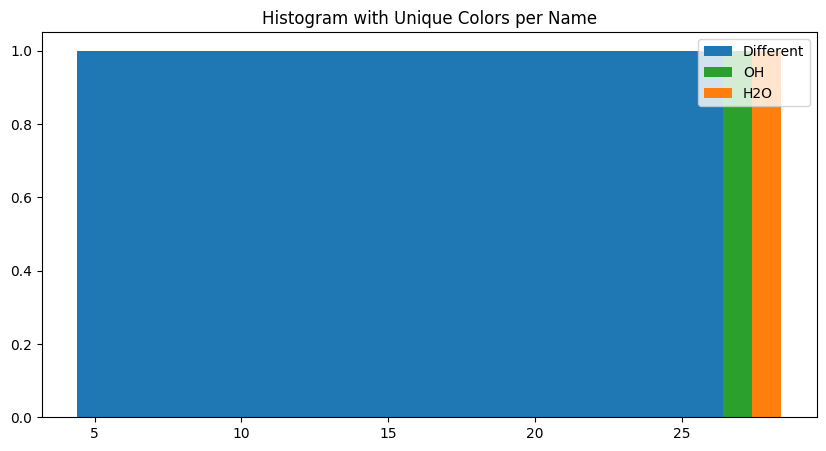

In [114]:
print(np.unique(dominant))
colors = plt.colormaps["tab10"].colors[:len(np.unique(dominant))]
name_colors = dict(zip(np.unique(dominant), colors))
new_species = species + ['Different']
# Create the histogram using plt.bar
plt.figure(figsize=(10, 5))
for i in range(len(windows)):
    plt.bar(windows[i], 1, width=window_size, color=name_colors[dominant[i]], label=new_species[dominant[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

# Formatting
# plt.xlabel("Bins")
# plt.ylabel("Frequency")
plt.title("Histogram with Unique Colors per Name")
# plt.xlim(26.8, 27)

plt.show()

In [64]:
print(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0])

[ 4.91029534  4.91031172  4.9103281  ... 28.22970979 28.22980395
 28.22989812]


In [82]:
def prepare_species_data(model_names, species):
    """
    Processes the given arrays of wavelength and flux for each species and generates the species_data dictionary.
    The dictionary is structured as:
    species_data[model][species] = {'wavelength': np.array([...]), 'flux': np.array([...])}
    
    Args:
    - model_names: List of model names.
    - species: List of species names.
    - wavelength_data: Dictionary of wavelength arrays indexed by model and species.
    - flux_data: Dictionary of flux arrays indexed by model and species.
    
    Returns:
    - species_data: Dictionary structured for Numba compatibility.
    """
    species_data = {}

    # Loop through the models and species to fill the species_data dictionary
    for model in model_names:
        species_data[model] = {}
        for specie in species:
            # Assign wavelength and flux arrays from provided data
            species_data[model][specie] = {
                'wavelength': df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0],
                'flux': df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0]
            }

    return species_data

def spectral_window(min_wl, max_wl, window_size, species, model_names, species_data, minimum):
    # Generate windows
    windows_array = np.arange(min_wl, max_wl, window_size)
    dom = np.full((25, len(windows_array)), -1)  # Use -1 or another integer to represent the '...'
    indices = np.arange(len(windows_array))

    # Loop through the models
    for index_model, model in tqdm(enumerate(model_names)):
        for index_window, window in enumerate(windows_array):
            if index_window in indices:
                dominant_specie_index = -1
                max_flux = -np.inf

                for specie_index, specie in enumerate(species):
                    wavelength = species_data[model][specie]['wavelength']
                    flux = species_data[model][specie]['flux']
                    
                    flux_value = calc_flux(wavelength, flux, [window, window + window_size])

                    if flux_value > max_flux:
                        max_flux = flux_value
                        dominant_specie_index = specie_index

                dom[index_model, index_window] = dominant_specie_index

        # Check for same values across models up to the current model
        same_values = np.all(dom[:index_model + 1] == dom[:index_model + 1][0, :], axis=0)
        indices = np.where(same_values)[0]

    return windows_array, dom[-1]

window_size = .01
min_wl = 4.9
max_wl = 28.5
model_names = list(df['Model Name'])
species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species_data = prepare_species_data(model_names, species)
windows, dominant = spectral_window(min_wl, max_wl, window_size, species,  model_names, species_data, 0.001)


25it [02:56,  7.05s/it]


In [122]:
def compress_to_numpy(model_names, species):
    # Initialize an empty 3D object array to store wavelength and flux data
    dim1 = len(model_names)
    dim2 = len(species)

    # Create a 3D object array, where each element can hold an array of varying length
    arr = np.empty((dim1, dim2, 2), dtype=object)  # '2' for wavelength and flux

    # Loop through each combination of model_names and species
    for i, model_name in enumerate(model_names):
        for j, species_name in enumerate(species):
            # Get the wavelength and flux from the dataframe
            wavelength = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Wavelength'].values[0]
            flux = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Flux'].values[0]
            
            # Store the wavelength and flux arrays in the object array
            arr[i, j, 0] = wavelength  # Store wavelength
            arr[i, j, 1] = flux       # Store flux
    
    return arr

arr = compress_to_numpy(model_names, species)

def spectral_window(min_wl, max_wl, window_size, arr):
    windows_array = np.arange(min_wl, max_wl, window_size)
    dom = np.full((25, len(windows_array)), -1)  # Use -1 or another integer to represent the '...'
    indices = np.arange(len(windows_array))

    for i in tqdm(np.arange(arr.shape[0])):
        for index_window, window in enumerate(windows_array):
            if index_window in indices:
                dominant_specie_index = -1
                max_flux = -np.inf

                for j in np.arange(arr.shape[1]): 
                    wavelength = arr[i, j, 0]
                    flux = arr[i, j, 1]
                    
                    flux_value = calc_flux(wavelength, flux, [window, window + window_size])

                    if flux_value > max_flux:
                        max_flux = flux_value
                        dominant_specie_index = j

                dom[i, index_window] = dominant_specie_index

        # Check for same values across models up to the current model
        same_values = np.all(dom[:i + 1] == dom[:i + 1][0, :], axis=0)
        indices = np.where(same_values)[0]

    return windows_array, dom[-1]
window_size = 0.001
windows, dominant = spectral_window(min_wl, max_wl, window_size, arr)

100%|██████████| 25/25 [17:11<00:00, 41.26s/it]


[-1  0  1  2  3  4  5  6  8]


C:\Users\niels\AppData\Local\Temp\ipykernel_2356\2198590584.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Spectral_regions.pdf')
C:\Users\niels\AppData\Local\Temp\ipykernel_2356\2198590584.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Spectral_regions.pdf')
C:\Users\niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


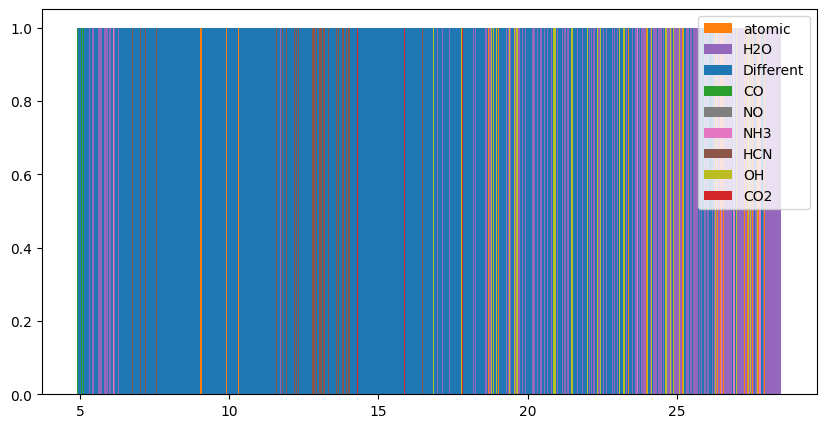

In [134]:
print(np.unique(dominant))
colors = plt.colormaps["tab10"].colors[:len(np.unique(dominant))]
name_colors = dict(zip(np.unique(dominant), colors))
new_species = species + ['Different']
# Create the histogram using plt.bar
plt.figure(figsize=(10, 5))
for i in range(len(windows)):
    plt.bar(windows[i], 1, width=window_size, color=name_colors[dominant[i]], label=new_species[dominant[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

# Formatting
# plt.xlabel("Bins")
# plt.ylabel("Frequency")
# plt.title("Histogram with Unique Colors per Name")
# plt.xlim(4.9, 5.2)
plt.savefig('Spectral_regions.pdf')
plt.show()